<a href="https://colab.research.google.com/github/dhhieu397/DeepLearningProjectDemo/blob/master/Bert_Covid_Sentiment_CLassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pandas
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, Flatten
import tensorflow_hub as hub
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [2]:
!pip install tensorflow_text
import tensorflow_text as text

     |████████████████████████████████| 4.9 MB 4.6 MB/s 
     |████████████████████████████████| 462 kB 60.2 MB/s 


In [3]:
import pandas as pd
train_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_train.csv')
val_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_valid.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_test.csv')



In [4]:
train_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,He was answering a question about the criticis...,1,0,1,0,0,0,0,1,0,0,0,0
1,1,I'm going to start today's discussion thread w...,1,1,1,1,0,0,0,1,0,0,0,0
2,2,"By announcing the 395 self-quarantined, it pai...",1,1,1,1,0,0,0,1,0,0,0,0
3,3,"Likewise, sorry if I offended you. I’m not act...",1,0,1,1,0,0,0,1,0,0,0,0
4,4,"People infected by experience high fever, coug...",0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
val_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0.0,He was answering a question about the criticis...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,I'm going to start today's discussion thread w...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,"By announcing the 395 self-quarantined, it pai...",1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,"Likewise, sorry if I offended you. I’m not act...",1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,"People infected by experience high fever, coug...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
test_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,&gt; # First passengers exit quarantined Japan...,0,1,0,1,0,0,1,0,1,0,0,0
1,1,"This is the best tl;dr I could make, [original...",0,0,0,0,0,0,0,0,0,0,0,1
2,2,Absolutely. Trade is good for everyone.\n\nBut...,0,0,1,0,0,0,0,0,0,0,0,0
3,3,He says the elderly should stay home. I have t...,0,0,0,1,0,0,0,1,0,0,0,0
4,4,&gt; A couple of million wont die in the US.\n...,0,1,0,1,0,0,0,1,1,1,0,0


In [7]:
#drop những trường data bị None
train_sentiment_data = train_data.dropna()
#reset index
train_sentiment_data = train_sentiment_data.reset_index(drop=True)

val_sentiment_data = val_data.dropna()
val_sentiment_data = val_sentiment_data.reset_index(drop=True)

test_sentiment_data = test_data.dropna()
test_sentiment_data = test_sentiment_data.reset_index(drop=True)

label_class = ['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust','neutral']
input_data_train = train_sentiment_data['text'].values
label_data_train = train_sentiment_data[label_class].values

input_data_val = val_sentiment_data['text'].values
label_data_val = val_sentiment_data[label_class].values

input_data_test = test_sentiment_data['text'].values
label_data_test = test_sentiment_data[label_class].values

print("Input train shape:",input_data_train.shape)
print("Label train shape:",label_data_train.shape)
print("Input val shape:",input_data_val.shape)
print("Label val shape:",label_data_val.shape)
print("Input test shape:",input_data_test.shape)
print("Label test shape:",label_data_test.shape)


Input train shape: (1493,)
Label train shape: (1493, 12)
Input val shape: (165,)
Label val shape: (165, 12)
Input test shape: (374,)
Label test shape: (374, 12)


#Train with Pretrain Word Embedding \
##Token based text embedding trained on English Google News 7B Corpus


In [8]:

embedding ="https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()
adam = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
    
))
    



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 48,192,964
Trainable params: 48,192,964
Non-trainable params: 0
_________________________________________________________________


In [9]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_google_embedding.h5', monitor='val_loss')
history = model.fit(x = input_data_train, y=label_data_train, epochs=50, validation_data =(input_data_val, label_data_val),callbacks=[callback_model])

Epoch 1/50
47/47 [==============================] - 12s 112ms/step - loss: 0.6227 - binary_accuracy: 0.6873 - val_loss: 0.5732 - val_binary_accuracy: 0.7111
Epoch 2/50
47/47 [==============================] - 4s 84ms/step - loss: 0.5503 - binary_accuracy: 0.7288 - val_loss: 0.5211 - val_binary_accuracy: 0.7268
Epoch 3/50
47/47 [==============================] - 4s 86ms/step - loss: 0.5061 - binary_accuracy: 0.7566 - val_loss: 0.4814 - val_binary_accuracy: 0.7540
Epoch 4/50
47/47 [==============================] - 4s 78ms/step - loss: 0.4625 - binary_accuracy: 0.7852 - val_loss: 0.4283 - val_binary_accuracy: 0.7955
Epoch 5/50
47/47 [==============================] - 3s 70ms/step - loss: 0.4171 - binary_accuracy: 0.8086 - val_loss: 0.3653 - val_binary_accuracy: 0.8500
Epoch 6/50
47/47 [==============================] - 3s 68ms/step - loss: 0.3697 - binary_accuracy: 0.8353 - val_loss: 0.3221 - val_binary_accuracy: 0.8641
Epoch 7/50
47/47 [==============================] - 3s 70ms/step - l

In [10]:
model.load_weights('model_google_embedding.h5')
model.evaluate(input_data_test, label_data_test)
preds = model.predict(input_data_test)
preds = tf.round(preds).numpy() #tf.round: làm tròn xuống
print(classification_report(label_data_test, preds, target_names=label_class, zero_division=0)) #y_true, y_pred, target_names: label_class

12/12 [==============================] - 0s 6ms/step - loss: 1.3936 - binary_accuracy: 0.7520
              precision    recall  f1-score   support

       anger       0.63      0.55      0.59       121
anticipation       0.69      0.63      0.66       218
     disgust       0.67      0.73      0.70       156
        fear       0.69      0.65      0.67       195
         joy       0.56      0.13      0.21        70
        love       0.25      0.07      0.11        30
    optimism       0.34      0.41      0.37        97
   pessimism       0.47      0.66      0.55       120
     sadness       0.49      0.36      0.42       136
    surprise       0.50      0.10      0.17        49
       trust       0.43      0.20      0.27        60
     neutral       0.75      0.08      0.14        38

   micro avg       0.58      0.50      0.54      1290
   macro avg       0.54      0.38      0.40      1290
weighted avg       0.58      0.50      0.51      1290
 samples avg       0.49      0.46      0

###Training with BERT

In [14]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  #preprocessing raw data = preprocessing cua tfhub, input la: raw text, not vector
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocesing')
  # du lieu text->vector thong qua preprocesing
  encoder_inputs = preprocessing_layer(text_input)
  #bert encoder
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output'] #(batch_size, 768)
  net = tf.keras.layers.Dense(400, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(200, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(100, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(50, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(12, activation='sigmoid', name='classifier')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  return tf.keras.Model(inputs=text_input, outputs=net)

classifier_model = build_classifier_model()
classifier_model.summary()
adam = Adam(learning_rate=0.01)
metric_acc = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)
classifier_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=metric_acc)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocesing (KerasLayer)      {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [15]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_small_bert.h5', monitor='val_loss')
history = classifier_model.fit(x = input_data_train, y=label_data_train, epochs=50, validation_data =(input_data_val, label_data_val),callbacks=[callback_model])

Epoch 1/50
47/47 [==============================] - 28s 445ms/step - loss: 1.1123 - binary_accuracy: 0.6839 - val_loss: 0.5447 - val_binary_accuracy: 0.6990
Epoch 2/50
47/47 [==============================] - 20s 430ms/step - loss: 0.9504 - binary_accuracy: 0.7037 - val_loss: 0.5442 - val_binary_accuracy: 0.6990
Epoch 3/50
47/47 [==============================] - 20s 434ms/step - loss: 0.9681 - binary_accuracy: 0.7095 - val_loss: 0.5422 - val_binary_accuracy: 0.6990
Epoch 4/50
47/47 [==============================] - 21s 444ms/step - loss: 0.9380 - binary_accuracy: 0.7129 - val_loss: 0.5474 - val_binary_accuracy: 0.6990
Epoch 5/50
47/47 [==============================] - 21s 441ms/step - loss: 0.9168 - binary_accuracy: 0.7123 - val_loss: 0.5476 - val_binary_accuracy: 0.6990
Epoch 6/50
47/47 [==============================] - 20s 436ms/step - loss: 0.9552 - binary_accuracy: 0.7151 - val_loss: 0.5415 - val_binary_accuracy: 0.6990
Epoch 7/50
47/47 [==============================] - 20s 43

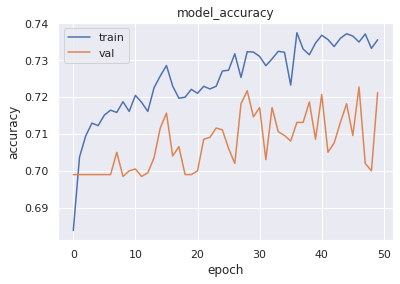

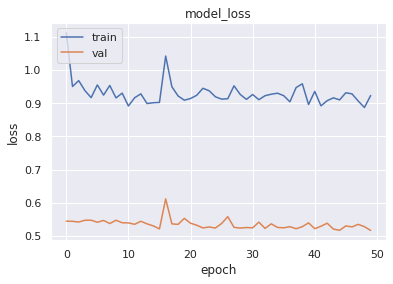

In [17]:
#summary history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


#summary history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()



In [19]:
classifier_model.load_weights('model_small_bert.h5')
classifier_model.evaluate(input_data_test, label_data_test)
preds = classifier_model.predict(input_data_test)
preds = tf.round(preds).numpy() #tf.round: làm tròn xuống
print(classification_report(label_data_test, preds, target_names=label_class, zero_division=0))

12/12 [==============================] - 5s 331ms/step - loss: 0.5246 - binary_accuracy: 0.7297
              precision    recall  f1-score   support

       anger       0.66      0.37      0.48       121
anticipation       0.61      0.08      0.14       218
     disgust       0.67      0.68      0.67       156
        fear       0.00      0.00      0.00       195
         joy       0.00      0.00      0.00        70
        love       0.00      0.00      0.00        30
    optimism       0.00      0.00      0.00        97
   pessimism       0.45      0.16      0.23       120
     sadness       0.00      0.00      0.00       136
    surprise       0.00      0.00      0.00        49
       trust       0.00      0.00      0.00        60
     neutral       0.00      0.00      0.00        38

   micro avg       0.63      0.14      0.24      1290
   macro avg       0.20      0.11      0.13      1290
weighted avg       0.29      0.14      0.17      1290
 samples avg       0.29      0.14     

In [20]:
#input: array 1 phần tử
test_input ='He was answering a question about the criticism by the same individual s that were referring to it as the chinese and Wuhan Corona Virus last'
def predict_sentiment(input, model):
  pred_result = classifier_model.predict([test_input])
  pred_result = list(tf.round( pred_result).numpy()[0])
  for v, l in zip(pred_result, label_class):
    if v ==1.0:
      print(l)

predict_sentiment(test_input, classifier_model)



anger
disgust


###Training with tradional LSTM +RNN

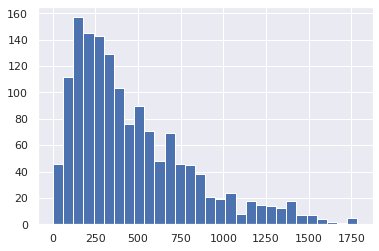

In [25]:
#get length of all the messages in the train set
seq_len = [len(i.split()) for i in input_data_train]
pd.Series(seq_len).hist(bins=30)

In [32]:
tokenizer_data = Tokenizer(oov_token='OOV', filters='', split=' ')
tokenizer_data.fit_on_texts(input_data_train)
tokenized_data_train =tokenizer_data.texts_to_sequences(input_data_train)
vec_data_train = pad_sequences(tokenized_data_train, padding='post', maxlen=250)

tokenized_data_val =tokenizer_data.texts_to_sequences(input_data_val)
vec_data_val = pad_sequences(tokenized_data_val, padding='post', maxlen=250)
data_vocab_size = len(tokenizer_data.word_index)+1 #word_index is used to find the length of the vector made. Use this the determine the extent of you vocabulary.
print("Input vec trainning: ",vec_data_train.shape)
print("Input vec val: ",vec_data_val.shape)
print("Vocab size: ",data_vocab_size)


Input vec trainning:  (1493, 250)
Input vec val:  (165, 250)
Vocab size:  69258


In [33]:
#Train with traditonal LSTM and RNN
dropout_threshold =0.4
model = Sequential()
input_dim = data_vocab_size
output_dim = 60
input_length = 250

#Add Embedding layer:
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
#Add bidirectional LSTM:
model.add(Bidirectional(LSTM(units=output_dim, dropout=dropout_threshold, return_sequences=True), merge_mode='concat'))
model.add(Bidirectional(LSTM(units=output_dim, dropout=dropout_threshold, return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dense(12, activation='sigmoid'))
adam = Adam(learning_rate=0.001)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
    
))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 60)           4155480   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 120)         58080     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 250, 120)         86880     
 nal)                                                            
                                                                 
 global_average_pooling1d (G  (None, 120)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_11 (Dense)            (None, 500)               60500     
                                                      

In [34]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_lstm.h5', monitor='val_loss')
history = model.fit(x = vec_data_train, y=label_data_train, epochs=50, validation_data =(vec_data_val, label_data_val),callbacks=[callback_model])

Epoch 1/50
47/47 [==============================] - 12s 77ms/step - loss: 0.5875 - binary_accuracy: 0.6997 - val_loss: 0.5425 - val_binary_accuracy: 0.6990
Epoch 2/50
47/47 [==============================] - 2s 46ms/step - loss: 0.5269 - binary_accuracy: 0.7318 - val_loss: 0.4981 - val_binary_accuracy: 0.7490
Epoch 3/50
47/47 [==============================] - 2s 45ms/step - loss: 0.4928 - binary_accuracy: 0.7527 - val_loss: 0.4538 - val_binary_accuracy: 0.7737
Epoch 4/50
47/47 [==============================] - 2s 45ms/step - loss: 0.4480 - binary_accuracy: 0.7734 - val_loss: 0.4141 - val_binary_accuracy: 0.7874
Epoch 5/50
47/47 [==============================] - 2s 45ms/step - loss: 0.4179 - binary_accuracy: 0.7882 - val_loss: 0.3983 - val_binary_accuracy: 0.7960
Epoch 6/50
47/47 [==============================] - 2s 44ms/step - loss: 0.3967 - binary_accuracy: 0.8005 - val_loss: 0.3659 - val_binary_accuracy: 0.8242
Epoch 7/50
47/47 [==============================] - 2s 45ms/step - lo

In [35]:
tokenized_data_test = tokenizer_data.texts_to_sequences(input_data_test)
vec_data_test = pad_sequences(tokenized_data_test, padding='post', maxlen=250)
model.load_weights('model_lstm.h5')
model.evaluate(vec_data_test, label_data_test)
preds = model.predict(vec_data_test)
preds = tf.round(preds).numpy() #tf.round: làm tròn xuống
print(classification_report(label_data_test, preds, target_names=label_class, zero_division=0))

12/12 [==============================] - 2s 28ms/step - loss: 0.8408 - binary_accuracy: 0.6916
              precision    recall  f1-score   support

       anger       0.43      0.72      0.54       121
anticipation       0.68      0.66      0.67       218
     disgust       0.50      0.72      0.59       156
        fear       0.63      0.43      0.51       195
         joy       0.62      0.14      0.23        70
        love       0.25      0.03      0.06        30
    optimism       0.29      0.25      0.27        97
   pessimism       0.36      0.84      0.51       120
     sadness       0.49      0.14      0.22       136
    surprise       0.15      0.18      0.17        49
       trust       0.23      0.18      0.20        60
     neutral       0.00      0.00      0.00        38

   micro avg       0.46      0.47      0.46      1290
   macro avg       0.39      0.36      0.33      1290
weighted avg       0.47      0.47      0.43      1290
 samples avg       0.44      0.43      